In [63]:
import function as f
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

In [64]:
folder_path = 'Results'
y_col = ['C_max_prev', 'C_max_now', 'C_max', 'Congestion_ratio_AVG', 'Congestion_ratio_AVG_prev', 'Congestion_ratio_AVG_now']

original_df = f.get_dfs_by_folder(folder_path, y_col, True, standard_outlier = y_col[2])

original_df = f.to_numeric(original_df, y_col[0])
original_df = f.to_numeric(original_df, y_col[1])
original_df = f.to_numeric(original_df, y_col[3])
original_df = f.to_numeric(original_df, y_col[4])
original_df = f.to_numeric(original_df, y_col[5])

# for file_name, df in c_max_df:
#     print(df[df.columns].dtypes)

for file_name, df in original_df:
    # add column
    df['Number of YT'] = int(df['Prev Truck Number'].unique()[0]) + int(df['Now Truck Number'].unique()[0])
    
original_df

all_alpha_df = pd.DataFrame()

# original_df에 있는 모든 파일을 합쳐 하나의 df로 만들기
for file_name, df in original_df:
    all_alpha_df = pd.concat([all_alpha_df, df], ignore_index=True)

all_alpha_df

Remove outliers by  C_max !


,Prev Truck Number,Now Truck Number,alpha_1,alpha_2,alpha_3,repeat_num,C_max_prev,C_max_now,C_max,Congestion_ratio_AVG,Congestion_ratio_AVG_prev,Congestion_ratio_AVG_now,Number of YT
0,5,5,0,0,100,1,404.816,396.952,404.816,0.036557,0.034676,0.038438,10
1,5,5,0,0,100,2,430.392,389.856,430.392,0.031613,0.046885,0.016342,10
2,5,5,0,0,100,3,395.136,403.208,403.208,0.047560,0.038560,0.056561,10
3,5,5,0,0,100,4,379.360,406.512,406.512,0.076458,0.058949,0.093967,10
4,5,5,0,0,100,5,367.512,419.168,419.168,0.023216,-0.013357,0.059789,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,30,30,80,10,10,56,441.536,448.848,448.848,0.286701,0.330823,0.242578,60
5650,30,30,80,10,10,57,429.856,444.728,444.728,0.332213,0.238609,0.425816,60
5651,30,30,80,10,10,58,433.640,446.616,446.616,0.371354,0.450646,0.292061,60
5652,30,30,80,10,10,59,451.176,440.272,451.176,0.260300,0.284196,0.236405,60


In [65]:
df  = all_alpha_df.copy()

# 'Number of YT'에 따라 데이터 분리하고, 'alpha_1', 'alpha_2', 'alpha_3'의 값이 같은 행끼리 묶은 뒤, 'Congestion_ratio_AVG_prev'의 평균 계산
avg_congestion_ratio_prev_by_yt = df.groupby(['Number of YT', 'alpha_1', 'alpha_2', 'alpha_3'])['Congestion_ratio_AVG_now'].mean().reset_index()

# 결과 출력
avg_congestion_ratio_prev_by_yt

# 'Number of YT'에 따라 데이터 분리
df_by_yt = avg_congestion_ratio_prev_by_yt.groupby(['Number of YT'])



# 각 그룹에 대해 순회
for yt, group_df in df_by_yt:
    # 첫 번째 행을 기준으로 Congestion_ratio_AVG_prev의 차이 계산
    first_row = group_df.iloc[0]
    group_df['Difference_from_first'] = ((group_df['Congestion_ratio_AVG_now'] - first_row['Congestion_ratio_AVG_now']) / first_row['Congestion_ratio_AVG_now']) * 100

    # 결과 출력
    print(f"\nNumber of YT: {yt}\n")
    print(group_df[['Difference_from_first']])


Number of YT: 10

   Difference_from_first
0               0.000000
1              -6.966561
2              -4.118768
3              17.723777
4              -3.951600
5               3.540418
6              -4.271644
7              -3.391255
8               6.095404

Number of YT: 15

    Difference_from_first
9                0.000000
10             -12.944490
11             -11.515828
12             -17.200274
13             -11.235628
14             -25.205677
15             -20.591796
16             -16.005034
17             -25.246949

Number of YT: 20

    Difference_from_first
18               0.000000
19             -19.914486
20             -29.118113
21             -19.022834
22             -26.996505
23             -28.816416
24             -21.362520
25             -14.462188
26             -28.274101

Number of YT: 25

    Difference_from_first
27               0.000000
28             -26.737479
29             -16.452621
30             -12.695585
31              -3.05609

In [66]:

grouped_by_yt = avg_congestion_ratio_prev_by_yt.groupby(['Number of YT'])

# 새로운 데이터프레임을 생성하여 결과 저장
result_df = pd.DataFrame()

# 각 그룹에 대해 순회
for yt, group_df in grouped_by_yt:
    # 첫 번째 행을 기준으로 Congestion_ratio_AVG_prev의 차이 계산
    first_row = group_df.iloc[0]
    group_df['Difference_from_first'] = ((group_df['Congestion_ratio_AVG_now'] - first_row['Congestion_ratio_AVG_now']) / first_row['Congestion_ratio_AVG_now']) * 100

    # 결과를 새로운 데이터프레임에 추가
    result_df = pd.concat([result_df, group_df[['Number of YT', 'alpha_1', 'alpha_2', 'alpha_3', 'Congestion_ratio_AVG_now', 'Difference_from_first']]])

# 결과를 CSV 파일로 저장
result_df.to_csv('result.csv', index=False)

print("Result saved to 'result.csv'")


Result saved to 'result.csv'


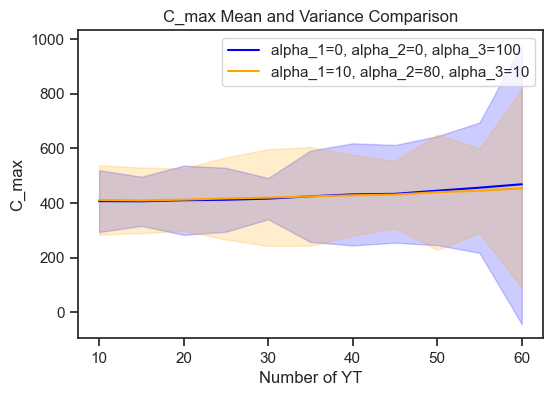

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = all_alpha_df.copy()

# 필요한 데이터 추출
alpha_1_data = df[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100)]
alpha_2_data = df[(df['alpha_1'] == 10) & (df['alpha_2'] == 80) & (df['alpha_3'] == 10)]

# Number of YT별 C_max의 평균값 계산
mean_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].mean()
mean_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].mean()

# Number of YT별 C_max의 분산 계산
var_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].var()
var_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].var()

# 그래프 그리기
plt.figure(figsize=(6, 4))

# 평균값에 대한 라인 플롯
sns.lineplot(x=mean_alpha_1.index, y=mean_alpha_1, label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
sns.lineplot(x=mean_alpha_2.index, y=mean_alpha_2, label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')

# 분산에 대한 그림자 표현
plt.fill_between(mean_alpha_1.index, mean_alpha_1 - var_alpha_1, mean_alpha_1 + var_alpha_1, color='blue', alpha=0.2)
plt.fill_between(mean_alpha_2.index, mean_alpha_2 - var_alpha_2, mean_alpha_2 + var_alpha_2, color='orange', alpha=0.2)

# 그래프 제목 및 레이블 설정
plt.title('C_max Mean and Variance Comparison')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

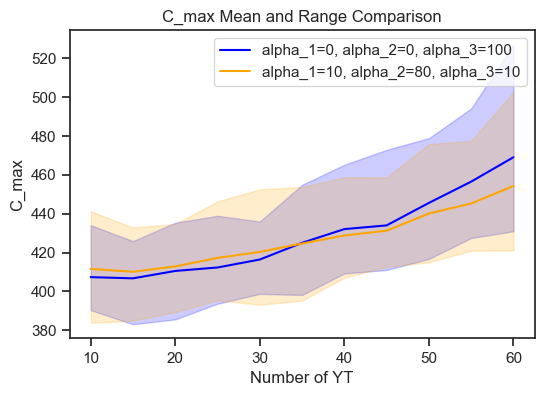

In [68]:
# 필요한 데이터 추출
alpha_1_data = df[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100)]
alpha_2_data = df[(df['alpha_1'] == 10) & (df['alpha_2'] == 80) & (df['alpha_3'] == 10)]

# Number of YT별 C_max의 평균값 계산
mean_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].mean()
mean_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].mean()

# Number of YT별 C_max의 최대, 최소값 계산
min_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].min()
max_alpha_1 = alpha_1_data.groupby('Number of YT')['C_max'].max()

min_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].min()
max_alpha_2 = alpha_2_data.groupby('Number of YT')['C_max'].max()

# 그래프 그리기
plt.figure(figsize=(6, 4))

# 평균값에 대한 라인 플롯
sns.lineplot(x=mean_alpha_1.index, y=mean_alpha_1, label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
sns.lineplot(x=mean_alpha_2.index, y=mean_alpha_2, label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')

# 실제 값의 범위에 대한 그림자 표현
plt.fill_between(mean_alpha_1.index, min_alpha_1, max_alpha_1, color='blue', alpha=0.2)
plt.fill_between(mean_alpha_2.index, min_alpha_2, max_alpha_2, color='orange', alpha=0.2)

# 그래프 제목 및 레이블 설정
plt.title('C_max Mean and Range Comparison')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

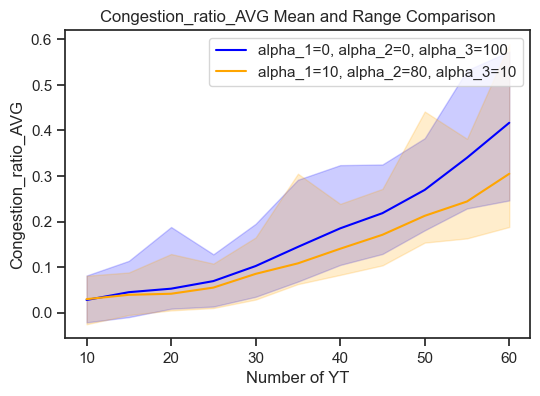

In [69]:
# 필요한 데이터 추출
alpha_1_data = df[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100)]
alpha_2_data = df[(df['alpha_1'] == 10) & (df['alpha_2'] == 80) & (df['alpha_3'] == 10)]

# Number of YT별 Congestion_ratio_AVG의 평균값 계산
mean_alpha_1 = alpha_1_data.groupby('Number of YT')['Congestion_ratio_AVG'].mean()
mean_alpha_2 = alpha_2_data.groupby('Number of YT')['Congestion_ratio_AVG'].mean()

# Congestion_ratio_AVG의 최대, 최소값 계산
min_alpha_1 = alpha_1_data.groupby('Number of YT')['Congestion_ratio_AVG'].min()
max_alpha_1 = alpha_1_data.groupby('Number of YT')['Congestion_ratio_AVG'].max()

min_alpha_2 = alpha_2_data.groupby('Number of YT')['Congestion_ratio_AVG'].min()
max_alpha_2 = alpha_2_data.groupby('Number of YT')['Congestion_ratio_AVG'].max()

# 그래프 그리기
plt.figure(figsize=(6, 4))

# 평균값에 대한 라인 플롯
sns.lineplot(x=mean_alpha_1.index, y=mean_alpha_1, label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
sns.lineplot(x=mean_alpha_2.index, y=mean_alpha_2, label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')

# 실제 값의 범위에 대한 그림자 표현
plt.fill_between(mean_alpha_1.index, min_alpha_1, max_alpha_1, color='blue', alpha=0.2)
plt.fill_between(mean_alpha_2.index, min_alpha_2, max_alpha_2, color='orange', alpha=0.2)

# 그래프 제목 및 레이블 설정
plt.title('Congestion_ratio_AVG Mean and Range Comparison')
plt.xlabel('Number of YT')
plt.ylabel('Congestion_ratio_AVG')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

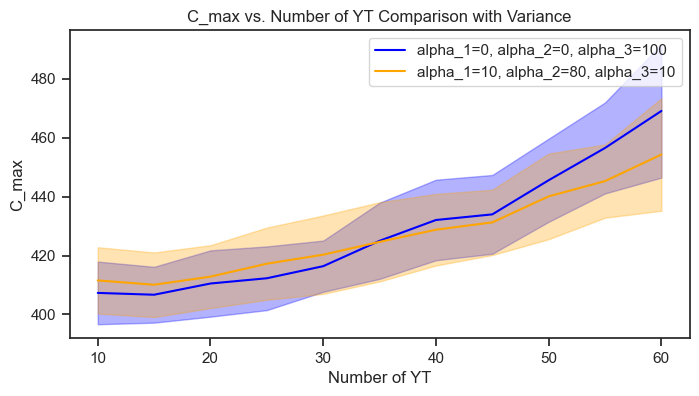

In [70]:

# alpha_1이 0, alpha_2가 0, alpha_3이 100인 행 추출
filtered_data_1 = df[(df['alpha_1'] == 0) & (df['alpha_2'] == 0) & (df['alpha_3'] == 100)]

# alpha_1이 10, alpha_2가 80, alpha_3이 10인 행 추출
filtered_data_2 = df[(df['alpha_1'] == 10) & (df['alpha_2'] == 80) & (df['alpha_3'] == 10)]

# 각각의 데이터에 대해 Number of YT 별로 C_max의 평균 및 분산 계산
grouped_data_1 = filtered_data_1.groupby('Number of YT')['C_max'].agg(['mean', 'std']).reset_index()
grouped_data_2 = filtered_data_2.groupby('Number of YT')['C_max'].agg(['mean', 'std']).reset_index()

# 그래프 그리기
plt.figure(figsize=(8, 4))

# 꺾은선 그래프 및 그림자 처리
plt.plot(grouped_data_1['Number of YT'], grouped_data_1['mean'], label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
plt.fill_between(
    grouped_data_1['Number of YT'],
    grouped_data_1['mean'] - grouped_data_1['std'],
    grouped_data_1['mean'] + grouped_data_1['std'],
    color='blue',
    alpha=0.3
)

plt.plot(grouped_data_2['Number of YT'], grouped_data_2['mean'], label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')
plt.fill_between(
    grouped_data_2['Number of YT'],
    grouped_data_2['mean'] - grouped_data_2['std'],
    grouped_data_2['mean'] + grouped_data_2['std'],
    color='orange',
    alpha=0.3
)

# 그래프 제목 및 레이블 설정
plt.title('C_max vs. Number of YT Comparison with Variance')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()


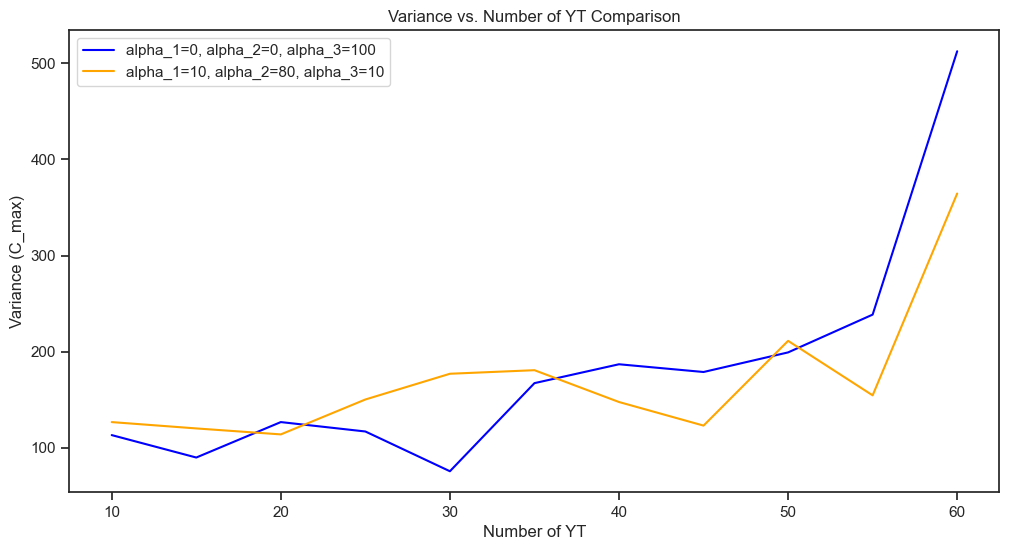

In [71]:
# 두 데이터셋에 대해 Number of YT에 따른 분산 계산
variance_data_1 = filtered_data_1.groupby('Number of YT')['C_max'].var().reset_index()
variance_data_2 = filtered_data_2.groupby('Number of YT')['C_max'].var().reset_index()

# 그래프 그리기
plt.figure(figsize=(12, 6))

plt.plot(variance_data_1['Number of YT'], variance_data_1['C_max'], label='alpha_1=0, alpha_2=0, alpha_3=100', color='blue')
plt.plot(variance_data_2['Number of YT'], variance_data_2['C_max'], label='alpha_1=10, alpha_2=80, alpha_3=10', color='orange')

# 그래프 제목 및 레이블 설정
plt.title('Variance vs. Number of YT Comparison')
plt.xlabel('Number of YT')
plt.ylabel('Variance (C_max)')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


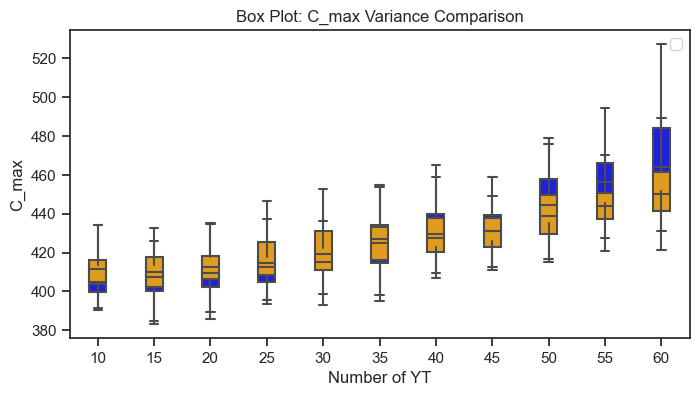

In [72]:
# 그래프 그리기
plt.figure(figsize=(8, 4))

sns.boxplot(x='Number of YT', y='C_max', data=filtered_data_1, color='blue', width=0.3,dodge=True, showfliers=False)
sns.boxplot(x='Number of YT', y='C_max', data=filtered_data_2, color='orange', width=0.3,dodge=True ,showfliers=False)

# 그래프 제목 및 레이블 설정
plt.title('Box Plot: C_max Variance Comparison')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

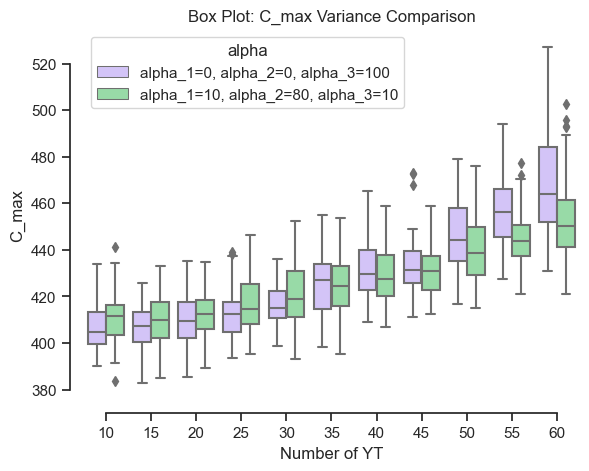

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임이 tips 대신 filtered_data_1과 filtered_data_2를 사용
sns.set_theme(style="ticks", palette="pastel")

# Combine the two datasets for visualization
combined_data = pd.concat([filtered_data_1.assign(alpha='alpha_1=0, alpha_2=0, alpha_3=100'), 
                           filtered_data_2.assign(alpha='alpha_1=10, alpha_2=80, alpha_3=10')])

# Draw a nested boxplot to show C_max by Number of YT and alpha
sns.boxplot(x="Number of YT", y="C_max",
            hue="alpha", palette=["m", "g"],
            data=combined_data)
sns.despine(offset=10, trim=True)

# Set the title and labels
plt.title('Box Plot: C_max Variance Comparison')
plt.xlabel('Number of YT')
plt.ylabel('C_max')

# Show the plot
plt.show()


#
alpha = [[0, 10, 20, 30, 40, 50, 60, 70, 80],
         [0, 80, 70, 60, 50, 40, 30, 20, 10],
         [100, 10, 10, 10, 10, 10, 10, 10, 10]]


c:\Users\USER\anaconda3\envs\hyeooi\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\USER\anaconda3\envs\hyeooi\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\USER\anaconda3\envs\hyeooi\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

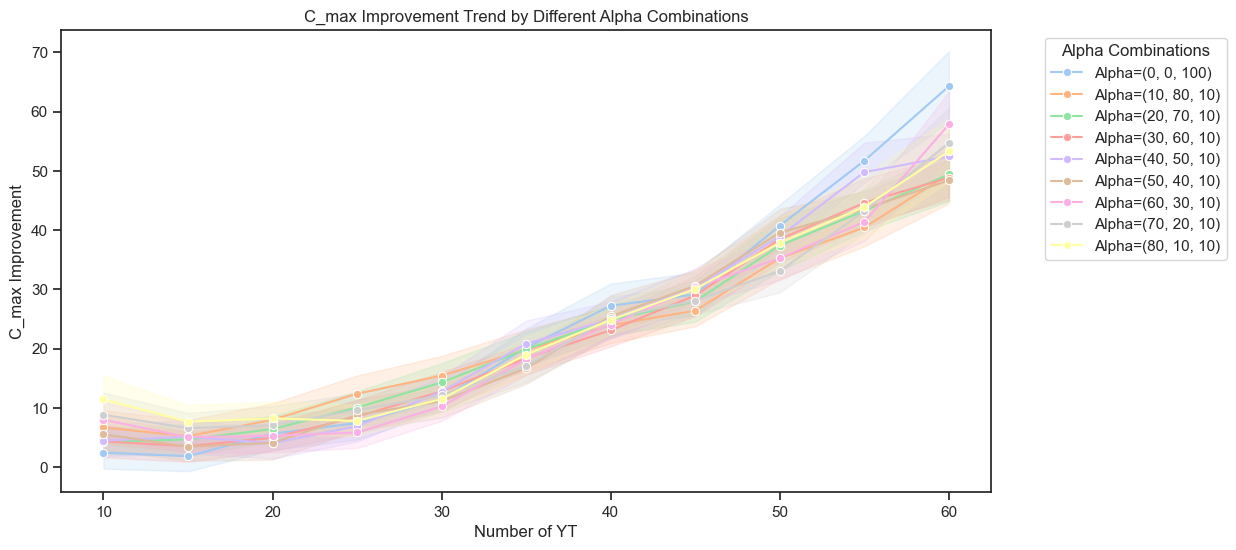

In [74]:
# 주어진 alpha값에 따라 데이터 필터링
alpha_values = [[0, 10, 20, 30, 40, 50, 60, 70, 80],
                [0, 80, 70, 60, 50, 40, 30, 20, 10],
                [100, 10, 10, 10, 10, 10, 10, 10, 10]]

# 그래프 그리기
plt.figure(figsize=(12, 6))

baseline_alpha = [0, 0, 100]  # Baseline alpha values

for alpha_combination in zip(*alpha_values):
    filtered_data = df[(df['alpha_1'] == alpha_combination[0]) & 
                       (df['alpha_2'] == alpha_combination[1]) & 
                       (df['alpha_3'] == alpha_combination[2])]
    
    baseline_data = df[(df['alpha_1'] == baseline_alpha[0]) & 
                       (df['alpha_2'] == baseline_alpha[1]) & 
                       (df['alpha_3'] == baseline_alpha[2])]
    
    # Calculate the performance improvement
    filtered_data['Performance Improvement'] = filtered_data['C_max'] - baseline_data['C_max'].values[0]
    
    sns.lineplot(x='Number of YT', y='Performance Improvement', label=f'Alpha={alpha_combination}', data=filtered_data, marker='o')

# 그래프 제목 및 레이블 설정
plt.title('C_max Improvement Trend by Different Alpha Combinations')
plt.xlabel('Number of YT')
plt.ylabel('C_max Improvement')

# 범례 추가
plt.legend(title='Alpha Combinations', bbox_to_anchor=(1.05, 1), loc='upper left')

# 그래프 표시
plt.show()